In [ ]:

import copy
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import tarfile
import torch
import torch.nn as nn

from torch import optim
from torch.nn import functional
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models, utils

In [ ]:
# download the data and the mapping between classes to labels
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz

In [ ]:
# unzip the folder and remove the compressed file
tar = tarfile.open("flower_data.tar.gz")
tar.extractall()
tar.close()


!rm -r flower_data.tar.gz

In [ ]:
# transformations for training data, imagenet expects 224 x 224 and certain normalization values
# values pulled from # imagenet values from https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224), # imagenet expects 224 x 224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) 
])

# transformations for validation and testing data, doesn't require augmentation, just resizing
validation_transforms = transforms.Compose([
    transforms.Resize(226),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(226),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder('train', transform=train_transforms)
val_data = datasets.ImageFolder('valid', transform=validation_transforms)
test_data = datasets.ImageFolder('test', transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
with open('cat_to_name.json') as f:
  print(json.load(f))

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

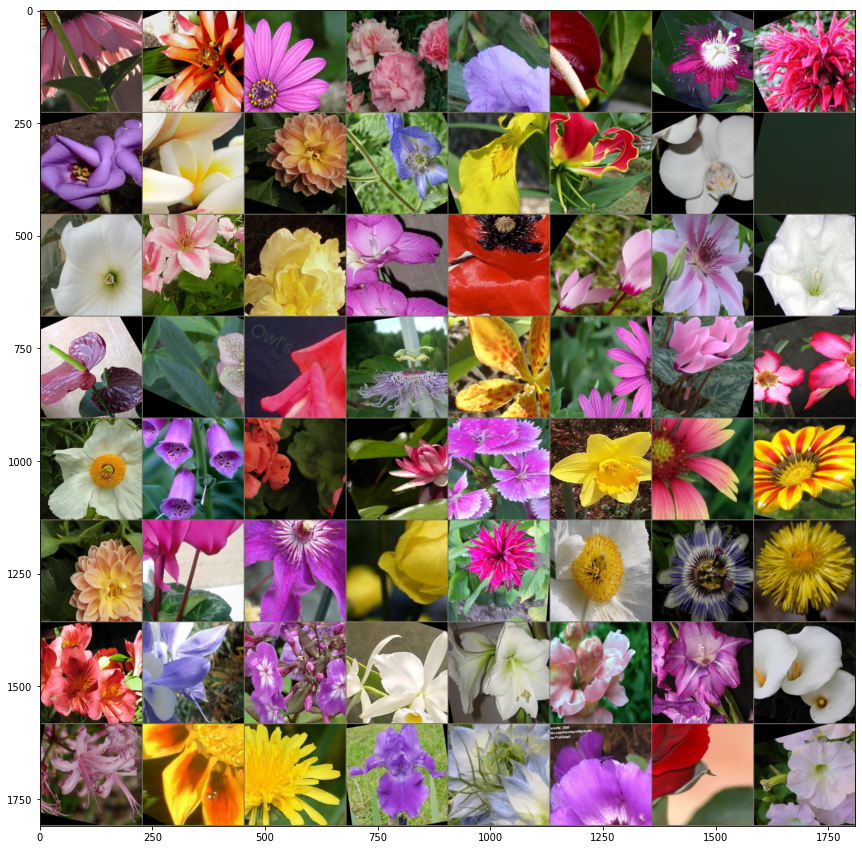

In [ ]:
def imshow(image):
    image = image.numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    plt.imshow(image)
    # ax.axis('off') 
        
images, _ = next(iter(train_loader))
out = utils.make_grid(images, nrow=8)
imshow(out)

In [ ]:
model = models.vgg16(pretrained=True)
model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# freeze the model parameters since we only want to replace and train the clssifier
# I found that with this the performance was bad so just use vgg as a starting point but modify its params during training
# for params in model.parameters():
#   params.requires_grad = False


In [ ]:
classifier = nn.Sequential(
    nn.Linear(25088, 5120),
    nn.ReLU(inplace=True),
    nn.Dropout(p=.2),
    nn.Linear(5120, 102)
)
model.classifier = classifier

In [26]:
class EarlyStopping:
  def __init__(self, min_delta: float, patience: int):
    """
    Args:
      min_delta(float): the difference between best metric 
        value and the its current val which needs to be exceeded to not stop
      patience(int): number of epochs that we tolerate no/little improvement for
    """
    self.min_delta = min_delta
    self.patience = patience
    self.best_validation_loss = None
    self.stale_epochs = 0
    self.early_stop = False
  
  def __call__(self, validation_loss):
    if not self.best_validation_loss:
      self.best_validation_loss = validation_loss
    
    elif self.best_validation_loss - validation_loss <= self.min_delta:
      if self.stale_epochs <= self.patience:
        self.stale_epochs += 1
      else:
        self.early_stop = True

    else:
      self.stale_epochs = 0
      self.best_validation_loss = validation_loss

In [27]:
es = EarlyStopping(.1, 3)
es(1)


In [30]:
es.early_stop

False

In [ ]:
def validate(model, val_loader, val_size, criterion, device="cpu"):
  running_corrects, running_loss = 0, 0
  for inputs, labels in iter(val_loader):
    
    inputs, labels = inputs.to(device), labels.to(device)


    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    running_loss += criterion(outputs, labels).item()
    running_corrects += (preds == labels.data).sum()
  
  validation_accuracy = running_corrects / val_size
  validation_loss = running_loss / val_size
  return validation_accuracy, validation_loss  

In [34]:
def train(model, train_loader, train_size, val_loader, val_size, criterion, optimizer, scheduler, epochs=10, device="cpu"):

  best_model = copy.deepcopy(model.state_dict())
  best_accuracy = 0
  model.to(device)
  es = EarlyStopping(min_delta=.1, patience=4)

  for epoch in range(epochs):
    model.train() # train mode for dropout to be applied
    
    running_loss = 0
    running_correct = 0
    for data, labels in iter(train_loader):
      data, labels = data.to(device), labels.to(device)
      
      # 1. clean the gradients
      optimizer.zero_grad()

      # 2. forward
      outputs = model(data)

      # 3. loss
      loss = criterion(outputs, labels)

      # 4. accumulate the partial derivatives
      loss.backward()

      # 5. update the params in the opposite direction of grads
      optimizer.step()
      
      # compute acc and loss
      _, preds = torch.max(outputs, 1)
      
      running_correct += (preds == labels.data).sum()
      running_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
      validation_accuracy, validation_loss = validate(model, val_loader, val_size, criterion, device)
      if validation_accuracy > best_accuracy:
        best_model = copy.deepcopy(model.state_dict())
    train_accuracy = running_correct / train_size
    train_loss = running_loss / train_size
    scheduler.step(validation_loss)
    print(f"Completed epoch {epoch + 1} and the TRAIN accuracy is {train_accuracy:.4f} and TRAIN loss is {train_loss:.4f}")
    print(f"Completed epoch {epoch + 1} and the VAL accuracy is {validation_accuracy:.4f} and VAL loss is {validation_loss:.4f}")
    print("-"*25, "\n")
    es(validation_loss)
    if es.early_stop:
      break
  
      

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = .001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
train(model, train_loader, len(train_data), val_loader, len(val_data), criterion, optimizer, scheduler, device="cuda")

Completed epoch 1 and the TRAIN accuracy is 0.8384 and TRAIN loss is 0.0122
Completed epoch 1 and the VAL accuracy is 0.8863 and VAL loss is 0.0232
------------------------- 

Completed epoch 2 and the TRAIN accuracy is 0.8413 and TRAIN loss is 0.0106
Completed epoch 2 and the VAL accuracy is 0.8778 and VAL loss is 0.0233
------------------------- 

Completed epoch 3 and the TRAIN accuracy is 0.8332 and TRAIN loss is 0.0109
Completed epoch 3 and the VAL accuracy is 0.8814 and VAL loss is 0.0228
------------------------- 

Completed epoch 4 and the TRAIN accuracy is 0.8291 and TRAIN loss is 0.0118
Completed epoch 4 and the VAL accuracy is 0.8839 and VAL loss is 0.0219
------------------------- 

Completed epoch 5 and the TRAIN accuracy is 0.8365 and TRAIN loss is 0.0107
Completed epoch 5 and the VAL accuracy is 0.8851 and VAL loss is 0.0234
------------------------- 

Completed epoch 6 and the TRAIN accuracy is 0.8309 and TRAIN loss is 0.0112
Completed epoch 6 and the VAL accuracy is 0.

In [1]:
def test(model, test_loader, test_size, criterion, device="cpu"):
  running_corrects, running_loss = 0, 0

  for data, labels in iter(test_loader):
    data, labels = data.to(device), labels.to(device)
    outputs = model(data)
    running_loss += criterion(outputs, labels).item()

    preds = torch.max(outputs, 1)
    running_corrects += (preds == labels.data).sum()

  accuracy = running_corrects / test_size
  loss = running_loss / test_size

  print(f"Test accuracy is {accuracy:.3f} and loss is {loss:.3f}")
  return accuracy, loss


In [2]:
test(model, test_loader, len(test_data), criterion, 'cuda')

NameError: ignored

In [ ]:
# save the model
